## Testing NC backboning over time (across 20 years)

Playing around with the module in util (had to write one from scratch as there is no noise corrected function in the backbone module) and different alpha values

In [108]:
import sys
import os
import pandas as pd
import networkx as nx

df = pd.read_csv('../data/CosciaRios2012_DataBase.csv')
min_year = df['Year'].min()
max_year = df['Year'].max()
families = df.columns[3:]

# add parent directory to path so we can import from util
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# import module from util
from util.nc_backbone import nc_backbone
from util.project import project
from util.get_edge_list import get_edge_list

alpha_value = 0.999
G_backboned = {}
G_original = {}
edges_evol = {'year': [], 'bb_edges': [], 'og_edges': []}

for year in range(min_year, max_year + 1):
    df_year = df[df['Year'] == year]
    adj = project(df_year, on_municipalities=False)
    edge_list = get_edge_list(adj)

    G_original[year] = nx.Graph()
    G_original[year].add_nodes_from(families)
    G_original[year].add_weighted_edges_from(edge_list)

    bb_edge_list = nc_backbone(adj, alpha=alpha_value)

    G_backboned[year] = nx.Graph()
    G_backboned[year].add_nodes_from(families)
    G_backboned[year].add_weighted_edges_from(bb_edge_list)

    edges_evol['year'].append(year)
    edges_evol['bb_edges'].append(nx.density(G_backboned[year]))
    edges_evol['og_edges'].append(nx.density(G_original[year]))
    
df_edges_evol = pd.DataFrame(edges_evol)
df_edges_evol

,year,bb_edges,og_edges
0,1990,0.000000,0.000000
1,1991,0.000000,0.000000
2,1992,0.000000,0.022222
3,1993,0.044444,0.044444
4,1994,0.044444,0.044444
5,1995,0.044444,0.044444
6,1996,0.111111,0.111111
7,1997,0.044444,0.044444
8,1998,0.088889,0.088889
9,1999,0.044444,0.044444


How ideal is the alpha value?  
We don't want to isolate nodes that belong to the connected component before backboning

In [109]:
# Check for isolated nodes
for year in range(1990, 2011):
    isolated_orig = list(nx.isolates(G_original[year]))
    isolated_bb = list(nx.isolates(G_backboned[year]))
    new_isolated = set(isolated_bb) - set(isolated_orig)

    conn_comp_og = nx.number_connected_components(G_original[year])
    conn_comp_bb = nx.number_connected_components(G_backboned[year])

    print(f"{year}: {conn_comp_og} in the original network, {conn_comp_bb} in the backboned network")
    if new_isolated:
        print(f"\t Nodes {new_isolated} became isolated")

1990: 10 in the original network, 10 in the backboned network
1991: 10 in the original network, 10 in the backboned network
1992: 9 in the original network, 10 in the backboned network
	 Nodes {'Zetas', 'Tijuana'} became isolated
1993: 8 in the original network, 8 in the backboned network
1994: 8 in the original network, 8 in the backboned network
1995: 8 in the original network, 8 in the backboned network
1996: 6 in the original network, 6 in the backboned network
1997: 8 in the original network, 8 in the backboned network
1998: 6 in the original network, 6 in the backboned network
1999: 8 in the original network, 8 in the backboned network
2000: 7 in the original network, 7 in the backboned network
2001: 4 in the original network, 4 in the backboned network
2002: 6 in the original network, 6 in the backboned network
2003: 4 in the original network, 4 in the backboned network
2004: 3 in the original network, 3 in the backboned network
2005: 2 in the original network, 2 in the backbone

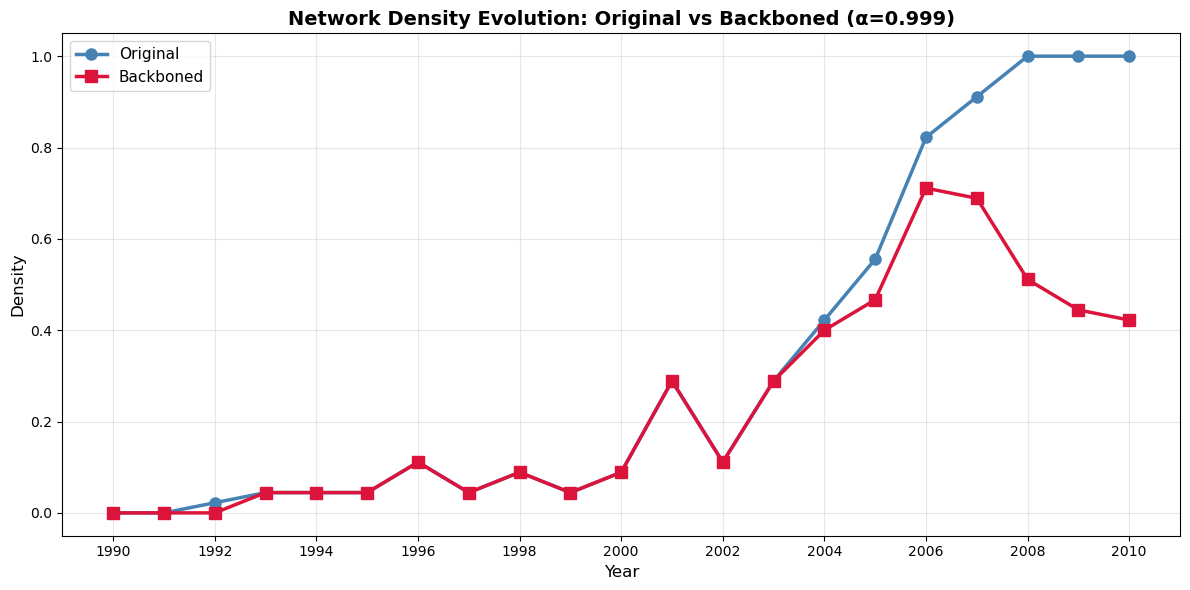

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_edges_evol['year'], df_edges_evol['og_edges'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_edges_evol['year'], df_edges_evol['bb_edges'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'Network Density Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

Smaller (and more reasonable) alpha values lead to very sparse backbones :(  
Filtering out the edge **(Golfo, Zetas)** before adding it to the sum of total weights not only does not help, but also returns less edges for the same alpha values without previous filtering. It is probably related to the fact that the prob of success increases, and the expected weight is way larger compared to the actual one.  
Interestingly, for the same alpha value, there is only aggressive backboning at the last four years, with years 2006 and 2007 retaining the most number of edges even though they are not cliques.
I tested several alpha values and α = 0.999 is best as it does not disconnect any nodes connected in the original network, and density changes pretty much allowing for more structural discoveries.

### Ridiculogram: 

In [111]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import imageio
import os

min_year = min(G_backboned.keys())
max_year = max(G_backboned.keys())
max_weight = 189 #hard coded from previous eda cartel projection notebook

G_og_2010 = nx.Graph()
df_2010 = df[df['Year'] == 2010]
adj_2010 = project(df_2010, on_municipalities=False)
edge_list_2010 = get_edge_list(adj_2010)
G_og_2010.add_nodes_from(families)
G_og_2010.add_weighted_edges_from(edge_list_2010)

# defining layout once (so positions are consistent across years) - used 2010 network as reference as it's the most dense of them all 
pos = nx.kamada_kawai_layout(G_og_2010, weight='weight') #nodes with higher weights are closer together

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

for year in range(min_year, max_year + 1):
    G = G_backboned[year]
    year_edges = G.edges()

    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    if len(year_edges) > 0:
        year_weights = np.array(list(G.edges(data='weight')))[:,2].astype(int)
        year_weights = year_weights / max_weight * 10  # normalize for plotting
        nx.draw_networkx_edges(G, pos, edgelist=year_edges, width=year_weights, edge_color="gray", alpha=0.6)    

    plt.title(f"NC Backboned Family Network - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{year:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/bb_network_evolution.gif', frames, fps=2)

# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'bb_network_evolution.gif'")

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_27768\674075588.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


Animation saved as 'bb_network_evolution.gif'


After visually inspecting this backboned projection, we observe some edges appear and disappear depending on the year, in contrast with the original projection where edges stay almost always and only get thicker.

Backboning on collapsed network

Edges in backboned nw: 6


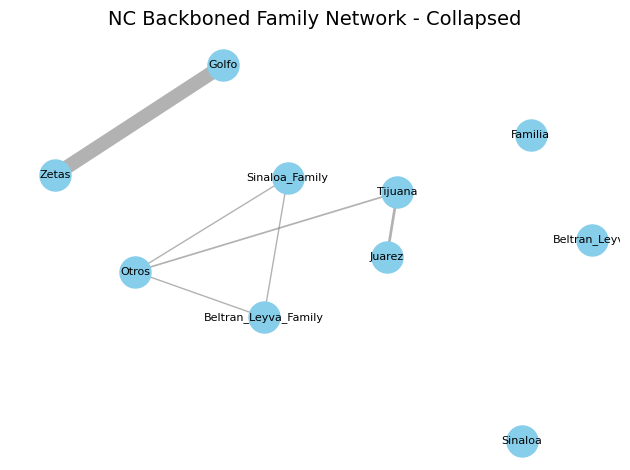

In [112]:
df_collapsed = df.groupby('Code').sum()
df_collapsed = (df_collapsed > 0).astype(int)

collapsed_adj = project(df_collapsed, on_municipalities=False)
collapsed_nc_edge_list = nc_backbone(collapsed_adj, alpha=alpha_value)
G_collapsed = nx.Graph()
G_collapsed.add_nodes_from(families)
G_collapsed.add_weighted_edges_from(collapsed_nc_edge_list)

np.array(G_collapsed.edges(data='weight'))

collapsed_weights = (np.array(list(G_collapsed.edges(data='weight'))))[:,2].astype(int)
collapsed_weights = collapsed_weights / max_weight * 5  # normalize for plotting

nx.draw_networkx_edges(G_collapsed, pos, width=collapsed_weights, edge_color="gray", alpha=0.6)
nx.draw_networkx_nodes(G_collapsed, pos, node_color="skyblue", node_size=500)
nx.draw_networkx_labels(G_collapsed, pos, font_size=8, font_color="black")

print(f"Edges in backboned nw: {G_collapsed.number_of_edges()}")

plt.title(f"NC Backboned Family Network - Collapsed", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

Surprisingly, the nc backboned collapsed network has way less edges than expected for the same alpha value. This suggests that the approach should be to either work with backboned time networks on a specific α or with the collapsed network at another alpha value.

### Stick to timed network
For completeness, we will mainly work with timed data, and compare results to collapsed network to analyze meaningful differences.

### Degree distribution
Plot the cumulative degree distribution from years 2004-2010 (both original and backbone)  
Show that none follow the power law (probably)

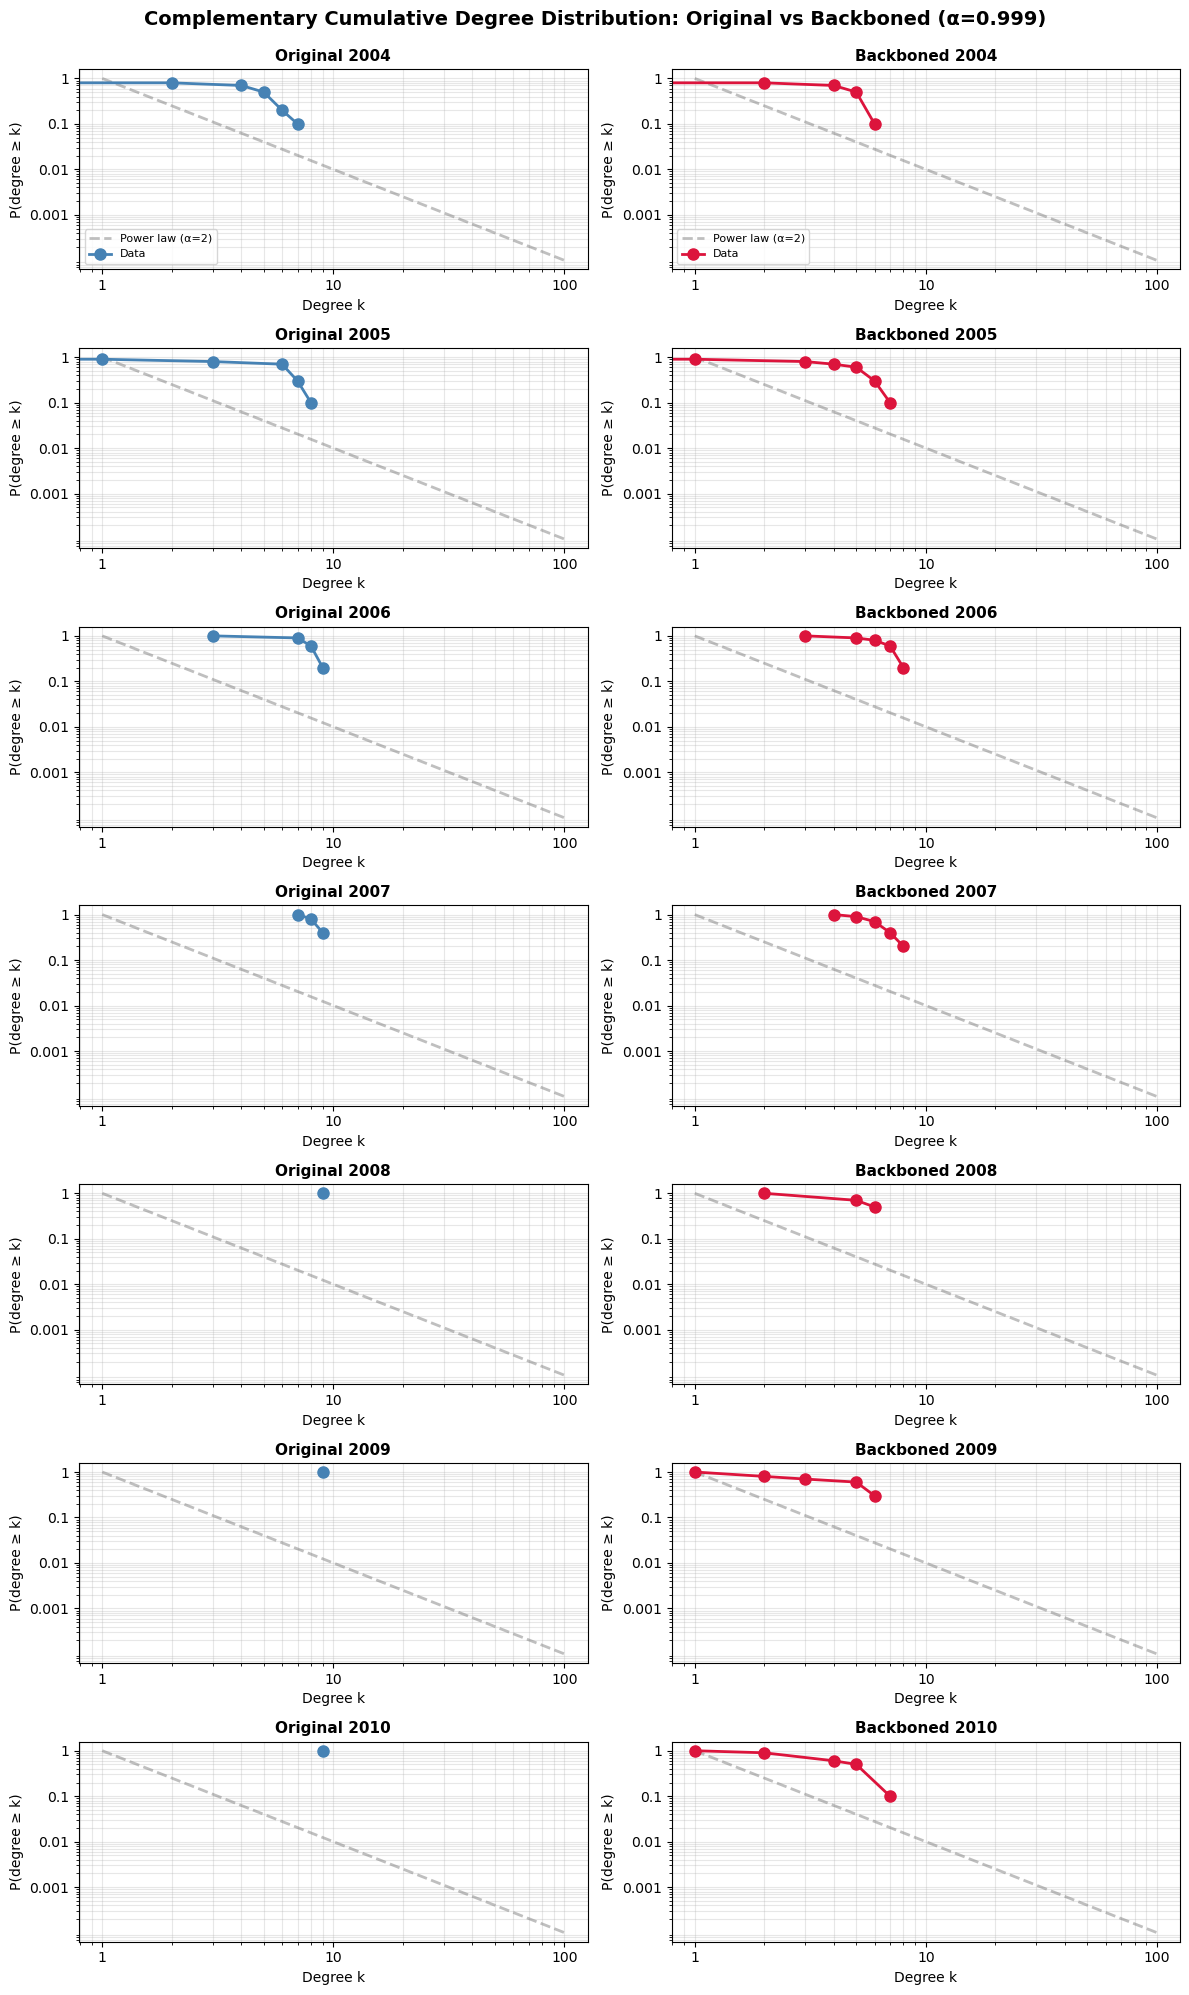

In [113]:
# Create 7x2 plot comparing complementary cumulative degree distributions (optimized)
import numpy as np

years_to_plot = list(range(2004, 2011))
fig, axes = plt.subplots(7, 2, figsize=(12, 20))

# Create reference power law: P(k) = k^(-alpha)
k_ref = np.linspace(1, 100, 100)
power_law_alpha = 2
power_law_ref = k_ref**(-power_law_alpha)  # Power law with exponent -1

for i, year in enumerate(years_to_plot):
    # Original network CCDF (left column)
    ax_orig = axes[i, 0]
    degrees_orig = np.array(list(dict(G_original[year].degree()).values()))
    total_nodes = G_original[year].number_of_nodes()
    
    # Get unique degrees and counts, then compute CCDF efficiently
    unique_degrees, counts = np.unique(degrees_orig, return_counts=True)
    ccdf_orig = np.cumsum(counts[::-1])[::-1] / total_nodes  # reverse cumsum for CCDF
    
    # Plot reference power law first (behind data)
    ax_orig.loglog(k_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_degrees) > 0:
        ax_orig.loglog(unique_degrees, ccdf_orig, 'o-', color='steelblue', markersize=8, linewidth=2, label='Data')
    
    ax_orig.set_xlabel('Degree k', fontsize=10)
    ax_orig.set_ylabel('P(degree ≥ k)', fontsize=10)
    ax_orig.set_title(f'Original {year}', fontsize=11, fontweight='bold')
    ax_orig.grid(True, alpha=0.3, which='both')
    ax_orig.set_xticks([1, 10, 100])
    ax_orig.set_yticks([0.001, 0.01, 0.1, 1])
    ax_orig.set_xticklabels(['1', '10', '100'])
    ax_orig.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_orig.legend(fontsize=8, loc='lower left')
    
    # Backboned network CCDF (right column)
    ax_bb = axes[i, 1]
    degrees_bb = np.array(list(dict(G_backboned[year].degree()).values()))
    total_nodes_bb = G_backboned[year].number_of_nodes()
    
    # Get unique degrees and counts, then compute CCDF efficiently
    unique_degrees_bb, counts_bb = np.unique(degrees_bb, return_counts=True)
    ccdf_bb = np.cumsum(counts_bb[::-1])[::-1] / total_nodes_bb  # reverse cumsum for CCDF
    
    # Plot reference power law first (behind data)
    ax_bb.loglog(k_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_degrees_bb) > 0:
        ax_bb.loglog(unique_degrees_bb, ccdf_bb, 'o-', color='crimson', markersize=8, linewidth=2, label='Data')
    
    ax_bb.set_xlabel('Degree k', fontsize=10)
    ax_bb.set_ylabel('P(degree ≥ k)', fontsize=10)
    ax_bb.set_title(f'Backboned {year}', fontsize=11, fontweight='bold')
    ax_bb.grid(True, alpha=0.3, which='both')
    ax_bb.set_xticks([1, 10, 100])
    ax_bb.set_yticks([0.001, 0.01, 0.1, 1])
    ax_bb.set_xticklabels(['1', '10', '100'])
    ax_bb.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_bb.legend(fontsize=8, loc='lower left')

plt.suptitle(f'Complementary Cumulative Degree Distribution: Original vs Backboned (α={alpha_value})', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../presentation/ccdf_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Impossible to state there is any kind of power law behavior, as the small number of nodes N limits the exponential behavior: the degree k has a max value of 9 and the power law follows the structure:
p(k) ~ k^(-α), meaning that as k → inf, p → 0. Besides, most nodes in the network have a degree of 1 as most real word networks are sparse, but in this case they are usually very dense. We tested at α=2 because real world power law networks have 2 ≤ α ≤ 5

**Better wording: With 𝑁 = 10, the degree distribution has no asymptotic regime, making any claim of power-law behavior or cutoff meaningless; the observed CCDF curvature is entirely due to finite-size constraints**

---

### Edge weight distribution
Plot the cumulative degree distribution from years 2004-2010 (both original and backbone)  
Show that none follow the power law (probably)

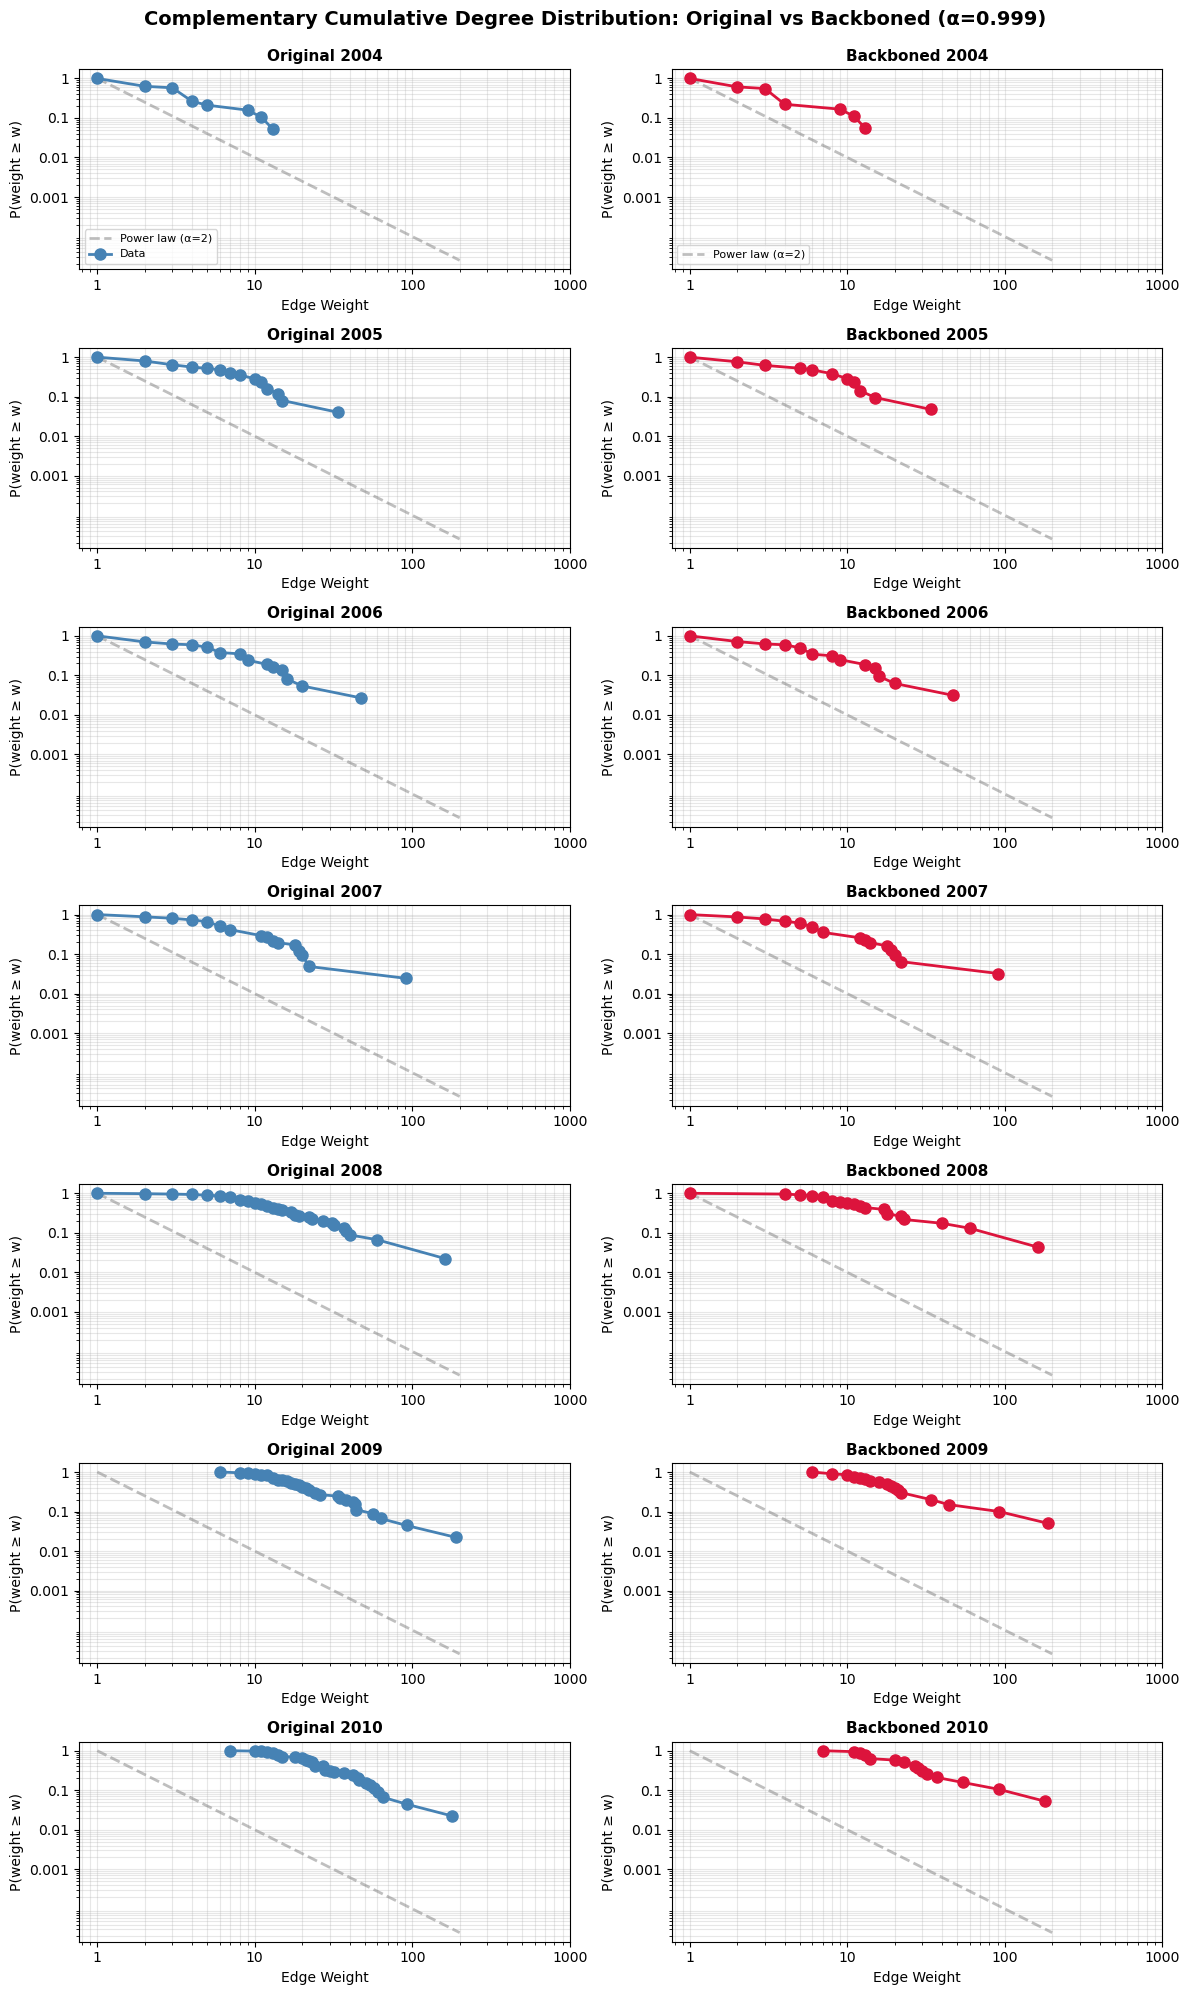

In [115]:
# Create 7x2 plot comparing complementary cumulative degree distributions (optimized)
import numpy as np

years_to_plot = list(range(2004, 2011))
fig, axes = plt.subplots(7, 2, figsize=(12, 20))

# Create reference power law for edge weights
w_ref = np.linspace(1, 200, 200)
power_law_alpha = 2
power_law_ref = w_ref**(-power_law_alpha)

for i, year in enumerate(years_to_plot):
    # Original network CCDF (left column)
    ax_orig = axes[i, 0]
    weights_orig = np.array(list(G_original[year].edges(data='weight')))[:,2].astype(int)
    total_edges = len(weights_orig)
    
    # Get unique weights and counts, then compute CCDF efficiently
    unique_weights, counts = np.unique(weights_orig, return_counts=True)
    ccdf_orig = np.cumsum(counts[::-1])[::-1] / total_edges  # reverse cumsum for CCDF

    # Plot reference power law first (behind data)
    ax_orig.loglog(w_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_weights) > 0:
        ax_orig.loglog(unique_weights, ccdf_orig, 'o-', color='steelblue', markersize=8, linewidth=2, label='Data')
    
    ax_orig.set_xlabel('Edge Weight', fontsize=10)
    ax_orig.set_ylabel('P(weight ≥ w)', fontsize=10)
    ax_orig.set_title(f'Original {year}', fontsize=11, fontweight='bold')
    ax_orig.grid(True, alpha=0.3, which='both')
    ax_orig.set_xticks([1, 10, 100, 1000])
    ax_orig.set_yticks([0.001, 0.01, 0.1, 1])
    ax_orig.set_xticklabels(['1', '10', '100', '1000'])
    ax_orig.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_orig.legend(fontsize=8, loc='lower left')
    
    # Backboned network CCDF (right column)
    ax_bb = axes[i, 1]
    weights_bb = np.array(list(G_backboned[year].edges(data='weight')))[:,2].astype(int)
    total_edges_bb = len(weights_bb)
    
    # Get unique weights and counts, then compute CCDF efficiently
    unique_weights_bb, counts_bb = np.unique(weights_bb, return_counts=True)
    ccdf_bb = np.cumsum(counts_bb[::-1])[::-1] / total_edges_bb  # reverse cumsum for CCDF

    # Plot reference power law first (behind data)
    ax_bb.loglog(w_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_weights_bb) > 0:
        ax_bb.loglog(unique_weights_bb, ccdf_bb, 'o-', color='crimson', markersize=8, linewidth=2)
    
    ax_bb.set_xlabel('Edge Weight', fontsize=10)
    ax_bb.set_ylabel('P(weight ≥ w)', fontsize=10)
    ax_bb.set_title(f'Backboned {year}', fontsize=11, fontweight='bold')
    ax_bb.grid(True, alpha=0.3, which='both')
    ax_bb.set_xticks([1, 10, 100, 1000])
    ax_bb.set_yticks([0.001, 0.01, 0.1, 1])
    ax_bb.set_xticklabels(['1', '10', '100', '1000'])
    ax_bb.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_bb.legend(fontsize=8, loc='lower left')

plt.suptitle(f'Complementary Cumulative Degree Distribution: Original vs Backboned (α={alpha_value})', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../presentation/ccdf_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Even though the weight value is not as limited as the degree value (which is max k=9), the power law distribution for edge weights is limited by the small sample size, where we have 45 weight values in the best case (when the network is a clique). 
The high similarity between edge weight plots makes sense since the NC backboning doesn't change weights, it only erases noisy edges, and in our case we observed the noisy ones are low weighted, so the weight distribution of the backboned network is dominated by the same high-weight edges that existed in the original.

---

### Diameter, APL, Density, CC
Plot each measurement's evolution over 1990-2010 for both versions (original network and backboned) and see how they diverge

#### Diameter

In [117]:
diam_evol = {'year': [], 'bb_diam': [], 'og_diam': []}

for year in range(min_year, max_year + 1):
    diam_evol['year'].append(year)

    # Original network diameter
    if nx.is_connected(G_original[year]):
        diam_evol['og_diam'].append(nx.diameter(G_original[year]))
    else:
        # Get largest connected component
        lcc_og = max(nx.connected_components(G_original[year]), key=len)
        G_lcc_og = G_original[year].subgraph(lcc_og)
        diam_evol['og_diam'].append(nx.diameter(G_lcc_og))
    
    # Backboned network diameter
    if nx.is_connected(G_backboned[year]):
        diam_evol['bb_diam'].append(nx.diameter(G_backboned[year]))
    else:
        # Get largest connected component
        lcc_bb = max(nx.connected_components(G_backboned[year]), key=len)
        G_lcc_bb = G_backboned[year].subgraph(lcc_bb)
        diam_evol['bb_diam'].append(nx.diameter(G_lcc_bb))
    
df_diam_evol = pd.DataFrame(diam_evol)
df_diam_evol

,year,bb_diam,og_diam
0,1990,0,0
1,1991,0,0
2,1992,0,1
3,1993,1,1
4,1994,2,2
5,1995,2,2
6,1996,3,3
7,1997,2,2
8,1998,3,3
9,1999,1,1


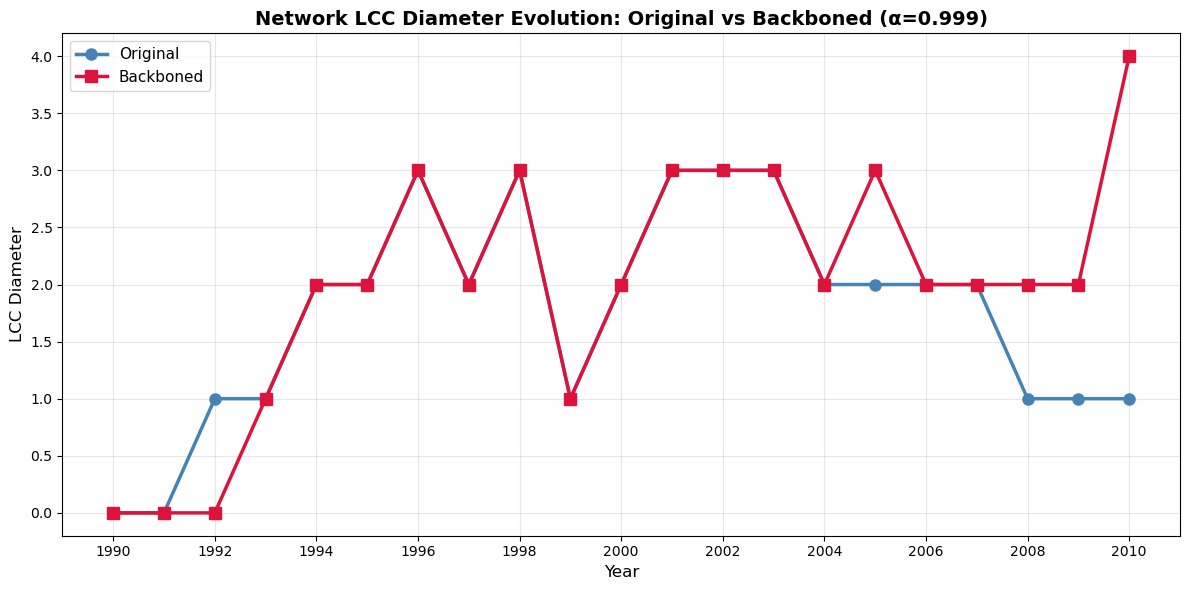

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_diam_evol['year'], df_diam_evol['og_diam'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_diam_evol['year'], df_diam_evol['bb_diam'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('LCC Diameter', fontsize=12)
plt.title(f'Network LCC Diameter Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

The fact that backboned diameter reaches 4 in 2010 suggests the cartel has distinct regional or functional modules connected through critical bridge families. The original complete network hides this by including many weak co-occurrences. Let's check the APL for better understanding of the network structure.

#### APL

In [ ]:
APL_evol = {'year': [], 'bb_apl': [], 'og_apl': []}

for year in range(min_year, max_year + 1):
    APL_evol['year'].append(year)

    # Original network APL
    if nx.is_connected(G_original[year]):
        og_apl = nx.average_shortest_path_length((G_original[year]))
    else:
        # Get largest connected component
        lcc_og = max(nx.connected_components(G_original[year]), key=len)
        G_lcc_og = G_original[year].subgraph(lcc_og)
        og_apl = nx.average_shortest_path_length(G_lcc_og)

    APL_evol['og_apl'].append(og_apl)
    
    # Backboned network APL
    if nx.is_connected(G_backboned[year]):
        bb_apl = nx.average_shortest_path_length((G_backboned[year]))
    else:
        # Get largest connected component
        lcc_bb = max(nx.connected_components(G_backboned[year]), key=len)
        G_lcc_bb = G_backboned[year].subgraph(lcc_bb)
        bb_apl = nx.average_shortest_path_length(G_lcc_bb)

    APL_evol['bb_apl'].append(bb_apl)
    
df_apl_evol = pd.DataFrame(APL_evol)
df_apl_evol

,year,bb_apl,og_apl
0,1990,0.000000,0.000000
1,1991,0.000000,0.000000
2,1992,0.000000,1.000000
3,1993,1.000000,1.000000
4,1994,1.333333,1.333333
5,1995,1.333333,1.333333
6,1996,1.700000,1.700000
7,1997,1.333333,1.333333
8,1998,1.800000,1.800000
9,1999,1.000000,1.000000


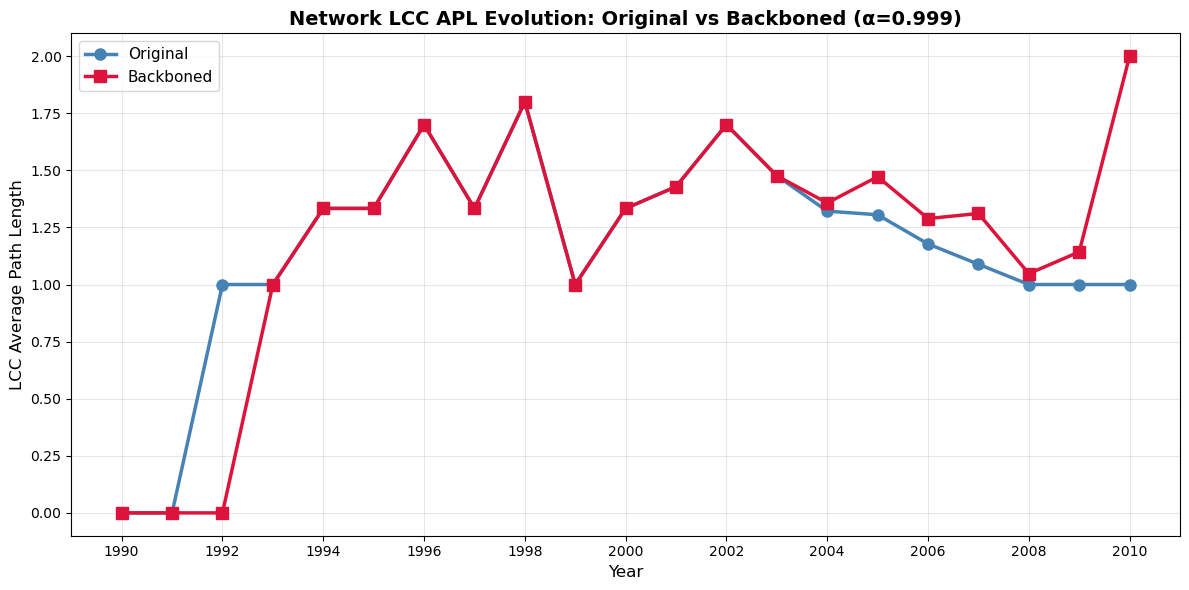

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_apl_evol['year'], df_apl_evol['og_apl'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_apl_evol['year'], df_apl_evol['bb_apl'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('LCC Average Path Length', fontsize=12)
plt.title(f'Network LCC APL Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_apl_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

**2010 (APL = 2.0, diameter = 4):**

Weights concentrated on specific edges (high heterogeneity)  
Many edges had low weights → failed NC test → removed  
Result: Sparse backboned network with chain-like or modular structure  
Few "strong" connections create bottlenecks → higher APL  

**2007-2009 (APL ≈ 1.0-1.5):**

Weights more uniformly distributed across edges  
More edges passed NC test → higher retention  
Result: Denser backboned network with many alternative paths  
Multiple redundant connections → lower APL  

*Why this matters:*  

A concentrated weight distribution in 2010 means:  
- A few family pairs had very high co-occurrence (strong ties)
- Many family pairs had low co-occurrence (weak ties)
- This creates inequality in territorial overlap

A uniform distribution in 2007-2009 means:  

- Most family pairs had similar co-occurrence levels
- More integrated territorial presence
- More cohesive operational structure

**The 2010 spike reveals: The cartel shifted from a cohesive territorial structure (2007-2009) to a more hierarchical or modular one with concentrated strong ties and many weak peripheral connections.**

---

### Assortativity Analysis: Power-based Edge Scatterplot

Testing whether powerful families (high municipal presence) preferentially co-occur with other powerful families

In [ ]:
# Calculate municipal presence for each family by year
def get_municipal_presence(df, year):
    """Returns dict {family: number of municipalities they're present in}"""
    df_year = df[df['Year'] == year]
    presence = {}
    for family in families:
        presence[family] = (df_year[family] > 0).sum()
    return presence

# Test for one year
presence_2010 = get_municipal_presence(df, 2010)
print("Municipal presence in 2010:")
for family, count in sorted(presence_2010.items(), key=lambda x: x[1], reverse=True):
    print(f"  {family}: {count} municipalities")

In [ ]:
# Create edge scatterplot for selected years
years_to_plot = [2004, 2007, 2010]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, year in enumerate(years_to_plot):
    presence = get_municipal_presence(df, year)
    
    # Original network
    ax_orig = axes[0, idx]
    G_orig = G_original[year]
    
    u_presence_orig = []
    v_presence_orig = []
    weights_orig = []
    
    for u, v, data in G_orig.edges(data=True):
        u_presence_orig.append(presence[u])
        v_presence_orig.append(presence[v])
        weights_orig.append(data['weight'])
    
    if weights_orig:
        scatter = ax_orig.scatter(u_presence_orig, v_presence_orig, 
                                 s=[w*10 for w in weights_orig],  # Scale point size
                                 c=weights_orig, cmap='YlOrRd', 
                                 alpha=0.6, edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax_orig)
        cbar.set_label('Co-occurrence count', fontsize=10)
        
        # Calculate correlation
        if len(u_presence_orig) > 1:
            corr = np.corrcoef(u_presence_orig, v_presence_orig)[0, 1]
            ax_orig.text(0.05, 0.95, f'r = {corr:.3f}', 
                        transform=ax_orig.transAxes, fontsize=11,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax_orig.set_xlabel('Municipal presence (family u)', fontsize=11)
    ax_orig.set_ylabel('Municipal presence (family v)', fontsize=11)
    ax_orig.set_title(f'{year} - Original', fontsize=12, fontweight='bold')
    ax_orig.grid(True, alpha=0.3)
    ax_orig.set_aspect('equal')
    
    # Backboned network
    ax_bb = axes[1, idx]
    G_bb = G_backboned[year]
    
    u_presence_bb = []
    v_presence_bb = []
    weights_bb = []
    
    for u, v, data in G_bb.edges(data=True):
        u_presence_bb.append(presence[u])
        v_presence_bb.append(presence[v])
        weights_bb.append(data['weight'])
    
    if weights_bb:
        scatter = ax_bb.scatter(u_presence_bb, v_presence_bb, 
                               s=[w*10 for w in weights_bb],
                               c=weights_bb, cmap='YlOrRd', 
                               alpha=0.6, edgecolors='black', linewidth=0.5)
        
        cbar = plt.colorbar(scatter, ax=ax_bb)
        cbar.set_label('Co-occurrence count', fontsize=10)
        
        # Calculate correlation
        if len(u_presence_bb) > 1:
            corr = np.corrcoef(u_presence_bb, v_presence_bb)[0, 1]
            ax_bb.text(0.05, 0.95, f'r = {corr:.3f}', 
                      transform=ax_bb.transAxes, fontsize=11,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax_bb.set_xlabel('Municipal presence (family u)', fontsize=11)
    ax_bb.set_ylabel('Municipal presence (family v)', fontsize=11)
    ax_bb.set_title(f'{year} - Backboned (α={alpha_value})', fontsize=12, fontweight='bold')
    ax_bb.grid(True, alpha=0.3)
    ax_bb.set_aspect('equal')

plt.tight_layout()
plt.savefig('../presentation/assortativity_scatterplot.png', dpi=300, bbox_inches='tight')
plt.show()

### Mesoscale analysis: PLAN  
- Identification of clusters/modules (communities) - there will likely be 2  
- Roles within (core) and between (bridge) communities
- Answers: "What groups exist and how are they organized?"

How to do it:  
1. Betweenness centrality - High values indicate bridges (many paths pass through them)
2. Within-community degree z-score - High values indicate cores (well-connected within their module)
3. Participation coefficient - High values indicate bridges (connections spread across communities)

### Social Balance Theory